## Persistent Shock Model and Income Expectations


This module creates an example application extending $\texttt{PersistentShockConsumerType}$ from $\texttt{ConsGenIndShockModel}$. (*Hyperlink to GenIncProcessModel.ipynb)* 

Most simply, it solves a consumption-saving model with neither necessarily fully transitory nor fully permanent, for which persistent income is tracked as a state variable and follows an AR(1) process.

###  But what if beliefs about persistent income differ from actual ?

What if the consumer is having some beliefs about the persistence of his/her income process which differ from the *actual* persistent income?

We can use the class $\texttt{PersistentShockConsumerType}$ as an appropriate model to solve the problem of an identical consumer but for experiencing some beliefs about his income process.

Suppose the consumer *perceived* the persistence of his/her income process differently than what the *actual* one is. We can prepare the parameters to create instances of that class. 

In [1]:
# Initial imports and notebook setup, click arrow to show
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import os
from copy import copy

from HARK.ConsumptionSaving.ConsGenIncProcessModel import *
import HARK.ConsumptionSaving.ConsumerParameters as Params

from HARK.utilities import plotFuncs, plotFuncsDer
from time import clock
mystr = lambda number : "{:.4f}".format(number)

In [2]:
# This cell defines a dictionary to make an instance of "persistent idiosyncratic shocks" consumer
ExampleDict={
        "CRRA": 2.0,                           # Coefficient of relative risk aversion
        "Rfree": 1.03,                         # Interest factor on assets
        "DiscFac": 0.96,                       # Intertemporal discount factor
        "LivPrb" : [0.98],                     # Survival probability
        "AgentCount" : 10000,                  # Number of agents of this type (only matters for simulation)
        "aNrmInitMean" : 0.0,                  # Mean of log initial assets (only matters for simulation)
        "aNrmInitStd"  : 1.0,                  # Standard deviation of log initial assets (only for simulation)
        "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income (only matters for simulation)
        "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income (only matters for simulation)
        "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor (only matters for simulation)
        "T_age" : None,                        # Age after which simulated agents are automatically killed
        "T_cycle" : 1,                         # Number of periods in the cycle for this agent type
        "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
        "aXtraMax" : 30,                       # Maximum end-of-period "assets above minimum" value               
        "aXtraExtra" : [0.005,0.01],           # Some other value of "assets above minimum" to add to the grid
        "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
        "aXtraCount" : 48,                     # Number of points in the grid of "assets above minimum"
        "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
        "TranShkCount" : 7,                    # Number of points in discrete approximation to transitory income shocks
        "PermShkStd" : [0.1],                  # Standard deviation of log permanent income shocks
        "TranShkStd" : [0.1],                  # Standard deviation of log transitory income shocks
        "UnempPrb" : 0.05,                     # Probability of unemployment while working
        "UnempPrbRet" : 0.005,                 # Probability of "unemployment" while retired
        "IncUnemp" : 0.3,                      # Unemployment benefits replacement rate
        "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
        "tax_rate" : 0.0,                      # Flat income tax rate
        "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
        "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
        "CubicBool" : False,                   # Use cubic spline interpolation when True, linear interpolation when False
        "vFuncBool" : True,                    # Whether to calculate the value function during solution    
        "cycles": 0,                           # Make this type have an infinite horizon
        "pLvlPctiles" : np.concatenate(([0.001, 0.005, 0.01, 0.03], np.linspace(0.05, 0.95, num=19),[0.97, 0.99, 0.995, 0.999])),
        "PermGroFac" : [1.0],                  # Permanent income growth factor - long run permanent income growth doesn't work yet  
        "PrstIncCorr": 0.97,                 # Serial correlation coefficient for *perceived* persistence of income
    }
    
    

In [3]:
def updateActAndPcvdPrstFunc(CorrAct, CorrPcvd):
    '''This method creates the actual and perceived persistent income, and evaluates how much difference it makes
    
    Parameters
    ----------
    CorrAct : float
        Serial correlation coefficient for *actual* persistent income
    CorrPcvd : np.array
        List or array of *perceived* persistent income


    Returns
    -------
    Two instances of PersistentShockConsumerType with different 'PrstIncCorr'
    
    (Solution: consumption function, cFunc, and marginal propensity to consume, MPC.)
    '''     
    
    ExampleDict={
        "CRRA": 2.0,                           # Coefficient of relative risk aversion
        "Rfree": 1.03,                         # Interest factor on assets
        "DiscFac": 0.96,                       # Intertemporal discount factor
        "LivPrb" : [0.98],                     # Survival probability
        "AgentCount" : 10000,                  # Number of agents of this type (only matters for simulation)
        "aNrmInitMean" : 0.0,                  # Mean of log initial assets (only matters for simulation)
        "aNrmInitStd"  : 1.0,                  # Standard deviation of log initial assets (only for simulation)
        "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income (only matters for simulation)
        "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income (only matters for simulation)
        "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor (only matters for simulation)
        "T_age" : None,                        # Age after which simulated agents are automatically killed
        "T_cycle" : 1,                         # Number of periods in the cycle for this agent type
        "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
        "aXtraMax" : 30,                       # Maximum end-of-period "assets above minimum" value               
        "aXtraExtra" : [0.005,0.01],           # Some other value of "assets above minimum" to add to the grid
        "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
        "aXtraCount" : 48,                     # Number of points in the grid of "assets above minimum"
        "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
        "TranShkCount" : 7,                    # Number of points in discrete approximation to transitory income shocks
        "PermShkStd" : [0.1],                  # Standard deviation of log permanent income shocks
        "TranShkStd" : [0.1],                  # Standard deviation of log transitory income shocks
        "UnempPrb" : 0.05,                     # Probability of unemployment while working
        "UnempPrbRet" : 0.005,                 # Probability of "unemployment" while retired
        "IncUnemp" : 0.3,                      # Unemployment benefits replacement rate
        "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
        "tax_rate" : 0.0,                      # Flat income tax rate
        "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
        "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
        "CubicBool" : False,                   # Use cubic spline interpolation when True, linear interpolation when False
        "vFuncBool" : True,                    # Whether to calculate the value function during solution    
        "cycles": 0,                           # Make this type have an infinite horizon
        "pLvlPctiles" : np.concatenate(([0.001, 0.005, 0.01, 0.03], np.linspace(0.05, 0.95, num=19),[0.97, 0.99, 0.995, 0.999])),
        "PermGroFac" : [1.0],                  # Permanent income growth factor - long run permanent income growth doesn't work yet  
        "PrstIncCorr": CorrPcvd,                 # Serial correlation coefficient for *perceived* persistence of income
    }
    # Make an example of "Persistent Shock consumer" with CorrPcvd as PrstIncCorr
    PersistentExample = PersistentShockConsumerType(**ExampleDict)
    
    # Update the income process, the assets grid, the persistent income grid, and the terminal solution
    # with the *perceived* persistent income as PrstIncCorr
    PersistentExample.updatepLvlNextFunc() 
    
    # Update the grid of persistent income levels with the *perceived* value
    PersistentExample.updatepLvlGrid()
    
    # Solve the consumer's problem with *perceived* persistence 
    PersistentExample.solve()
    
    # Replace PrstIncCorr parameter with *actual* persistence
    ExampleDict['PrstIncCorr'] = CorrAct
    
    # Make another example of "Persistent Shock consumer" with CorrAct as PrstIncCorr
    PersistentExample2 = PersistentShockConsumerType(**ExampleDict)
    
    # Update the consumer's income process
    PersistentExample2.updateIncomeProcess()
    
    # Update the income process, the assets grid, the persistent income grid, and the terminal solution
    # with the *actual* persistent income
    PersistentExample2.updatepLvlNextFunc() 
    
    PersistentExample2.solve()
    
    return PersistentExample, PersistentExample2
    

The user needs to call the function $\texttt{updateActAndPcvdPrstFunc}$ with specific values for $\texttt{CorrAct}$ and $\texttt{CorrPcvd}$ to solve the model accordingly. 

In [4]:
# Call the function with specific values for (CorrAct,CorrPcvd)
PersistentExample, PersistentExample2 = updateActAndPcvdPrstFunc(0.9831, 0.97)


divide by zero encountered in double_scalars


Consumption function by persistent income level pLvl for a consumer with *perceived* AR1 coefficient of 0.97:


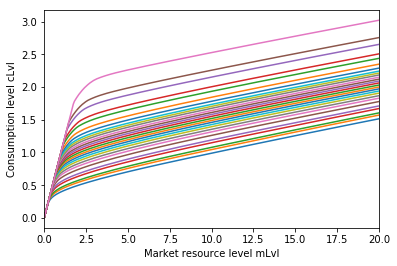

Consumption function by persistent income level pLvl for a consumer with *actual* AR1 coefficient of 0.9831:


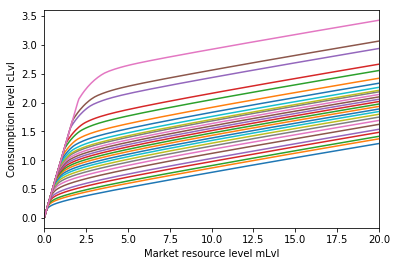

In [5]:
# Plot the consumption function when the agent perceives the persistence of his income process
print('Consumption function by persistent income level pLvl for a consumer with *perceived* AR1 coefficient of ' + str(PersistentExample.PrstIncCorr) + ':')
pLvlGrid = PersistentExample.pLvlGrid[0]
mLvlGrid = np.linspace(0,20,300)
for p in pLvlGrid:
    M_temp = mLvlGrid + PersistentExample.solution[0].mLvlMin(p)
    C = PersistentExample.solution[0].cFunc(M_temp,p*np.ones_like(M_temp))
    plt.plot(M_temp,C)
plt.xlim(0.,20.)
plt.xlabel('Market resource level mLvl')
plt.ylabel('Consumption level cLvl')
plt.show()
    
    
# Plot the consumption function when the agent truly evaluates the persistence of his income process
print('Consumption function by persistent income level pLvl for a consumer with *actual* AR1 coefficient of ' + str(PersistentExample2.PrstIncCorr) + ':')
pLvlGrid = PersistentExample2.pLvlGrid[0]
mLvlGrid = np.linspace(0,20,300)
for p in pLvlGrid:
    M_temp = mLvlGrid + PersistentExample2.solution[0].mLvlMin(p)
    C = PersistentExample2.solution[0].cFunc(M_temp,p*np.ones_like(M_temp))
    plt.plot(M_temp,C)
plt.xlim(0.,20.)
plt.xlabel('Market resource level mLvl')
plt.ylabel('Consumption level cLvl')
plt.show()

In [6]:
# Compare actual persistence vs beliefs about persistence

# Simulate some data